<a href="https://colab.research.google.com/github/GeniusGun/python/blob/master/project/coin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

tf.__version__
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

'1.15.0'

In [8]:
# Load Dataset
data = pd.read_csv("/content/drive/My Drive/CoinData/AMAZON_191118_5Y.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
Date         1259 non-null object
Open         1259 non-null float64
High         1259 non-null float64
Low          1259 non-null float64
Close        1259 non-null float64
Adj Close    1259 non-null float64
Volume       1259 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-11-18,323.989990,329.559998,323.250000,324.929993,324.929993,3549500
1,2014-11-19,327.250000,328.399994,324.019989,326.540009,326.540009,3281600
2,2014-11-20,324.000000,332.670013,323.329987,330.540009,330.540009,3436700
3,2014-11-21,335.420013,338.329987,331.470001,332.630005,332.630005,4466600
4,2014-11-24,334.779999,337.390015,333.600006,335.640015,335.640015,2754200


In [0]:
# Compute Mid Price
high_prices = data["High"].values
low_prices = data["Low"].values
mid_prices = high_prices + low_prices / 2
# mid_prices = data['Close']
# mid_prices

In [0]:
# data.info()

In [0]:
# Creat Windows
seq_len = 50                    # 최근 50일을 통해 내일을 예측
sequence_length = seq_len + 1   # 50일이 기준이되고 1일 뒤를 예측해야 하기 때문에 50 + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [0]:
# Normalize Data
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

In [13]:
# split train and test data
row = int(round(result.shape[0] * 0.3))    # 30%의 데이터로 트레이닝 후 70%의 데이터로 테스트검증
train = result[:row, :]     
np.random.shuffle(train)                   # 배열의 값을 랜덤으로 섞는다, 반복되는 데이터로 할 경우 익숙해짐

x_train = train[:, : -1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, : -1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((362, 50, 1), (846, 50, 1))

In [14]:
# Build a Model
model = Sequential()    # model.add() > 모델 레이어 추가
model.add(LSTM(50, return_sequences = True, input_shape = (50, 1)))     # 유닛수 50
model.add(LSTM(64, return_sequences = False))           # 유닛수 64
model.add(Dense(1, activation = "linear"))              # 다음날 하루를 예측
model.compile(loss = "mse", optimizer = "rmsprop")      # 손실함수 : mse(Mean Squared Error)
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Training
model.fit(x_train, y_train,     # model.fit() : 모델학습
          validation_data = (x_test, y_test),
          batch_size = 30,      # 한번에 묶어서 학습시킬 개수
          epochs = 1000)          # 반복할 학습 횟수

                                # >> val_loss 가 작을수록 학습이 잘 된것

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 362 samples, validate on 846 samples
Epoch 1/1000




362/362 [==============================] - 3s 7ms/step - loss: 0.0066 - val_loss: 0.0017
Epoch 2/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 3/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 4/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0021 - val_loss: 9.1271e-04
Epoch 6/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 9/1000
362/362 [=============

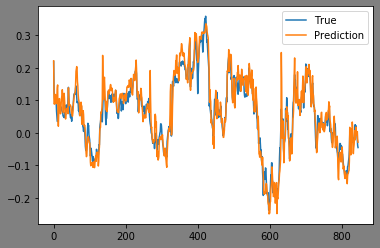

In [16]:
# Prediction
pred = model.predict(x_test)

fig = plt.figure(facecolor = "gray")
ax = fig.add_subplot(111)
ax.plot(y_test, label = "True")
ax.plot(pred, label = "Prediction")
ax.legend()
plt.show()